# Answering Business Questions Using SQL

## Introduction

This is my 10th DataQuest projoect in the Data Scientist Pathway

This is the 2nd project in Step 4 - Working with Data Sources

The purpose of this project is to analyze business questions using SQL. The project will be using the Chinook Database, which is a sampele database representing a digital media store namely for music. In contains information on the media such as track and albums name, as wells as invoices and customer information.

Below is an image of the entire database structure:

<img src="chinook.jpg">

Tools I'll be using include:

- Python 3
- SQLite3
- Numpy, Pandas, Matplotlib

First, I'll import the necessary packages and do some set-up in python to make working with SQL easier

In [1]:
## Load in packages
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

#Short-cut for database
db = "chinook.db"

# Easily run our query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# Earily run our queries, but don't return pd table
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)
    
# Display all the tables in the database and type
def show_tables():
    q = '''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
        '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Problem: Determining Popular Genre's in the USA

"The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. 

The record label specializes in artists from the USA, and have given Chinook some money to advertise the new albums in the USA."

Here are the new Artist's and Genre from the new record label:

<img src = "NewRecord.jpg">


The goal then is to determine which genre's which sell best in the USA, since the new albums have no previous tracks (or other information) to indicate their potential popularity.

This can be done by filtering for all sales in the USA, and then calculating the amount of tracks sold in each genre. With that done, a percentage of sales can be calculated and plotted.


In [2]:
query1 = '''
        WITH 
            sales_info AS
            (
            SELECT
                t.track_id,
                il.quantity,
                t.genre_id
            FROM track AS t
            INNER JOIN invoice_line AS il ON il.track_id = t.track_id
            INNER JOIN invoice AS i ON i.invoice_id = il.invoice_id            
            WHERE i.billing_country = "USA"           
            ),
            
            genre_info AS
            (
            SELECT 
                g.name,
                SUM(quantity) as quantity
            FROM sales_info AS s
            INNER JOIN genre AS g ON g.genre_id = s.genre_id
            GROUP BY g.name
            )
            
        SELECT
            name,
            quantity,
            ROUND((100.0*quantity)/ (SELECT 1.0*SUM(quantity) FROM genre_info), 2) AS percentage
        FROM genre_info
        ORDER BY quantity DESC
        LIMIT 10

        '''

top_genre_in_usa = run_query(query1)
run_query(query1)

,name,quantity,percentage
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


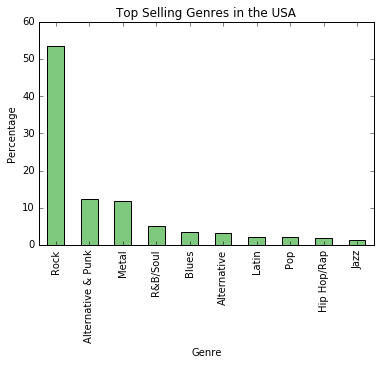

In [3]:
top_genre_in_usa.plot.bar(x="name", y="percentage", legend=False, colormap=plt.cm.Accent)
plt.title("Top Selling Genres in the USA")
plt.ylabel("Percentage")
plt.xlabel("Genre")


### Analysis

Although it's easy to determine the information from the table above, the graph makes it clear which genres are the best selling (in that their tracks are sold most often).

The top 4 genres are, from high to low:

1. Rock
2. Alternative & Punk
3. Metal
4. R&B / Soul

After the top 4, the percentages are very tight and poorly distinguished. 

Concerning the new record label, from the four different artists we should select, in the following order:

1. Red Tone
2. Slim Jim Bites
3. Meteor and the Girls
4. *Regal (and so the artist, by this standard, should not choosen)

## Problem: Reviewing Employee Performance

"Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others."

To goal is to identify employee performance, and review whatever information that exists within the database that might explain this performance.

A good place to start for basic employee performance is to determine the amount of sales earned per employee.

Factors to consider outside of this include:
1. Bosses or who the employee reports to: Leadership is invaluable in a work environment
2. Hire Data - If an employee is new, they will not have had the time to amount similiar sales compared with veteran employees



In [4]:
query2 = '''
        WITH 
        sales_info AS
        (
        SELECT
            e.first_name || " " || e.last_name AS employee_name,
            e.employee_id,
            c.customer_id,
            i.total
        FROM employee AS e
        INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        ),
        
        sales_perf AS
        (
        SELECT
            employee_name,
            SUM(total) sales
        FROM sales_info AS s
        GROUP BY employee_name
        ORDER BY sales
        )

        SELECT * FROM sales_perf

        '''
    
sales_performance = run_query(query2)
run_query(query2)


,employee_name,sales
0,Steve Johnson,1393.92
1,Margaret Park,1584.00
2,Jane Peacock,1731.51


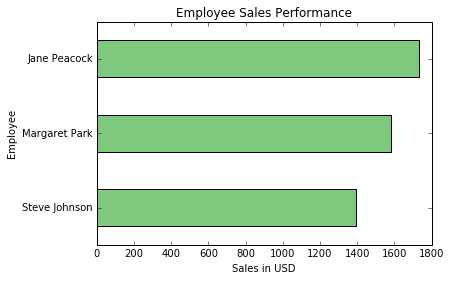

In [5]:
sales_performance.plot.barh(x="employee_name", y="sales",
                           title="Employee Sales Performance",
                            legend=False,
                            colormap=plt.cm.Accent)
plt.xlabel("Sales in USD")
plt.ylabel("Employee")

From the sales performance, it's clear that Jane Peacock has the highest amount of sales out of the three employees, and Steve Johnson has the lowest. 

I'll check the start date of each employee to see if this has any relevance to their scores. Lower sales can be understood if the employee has a corresponding work start date.

In [6]:
query2b = '''
        WITH
        sales_info AS
        (
        SELECT
            e.first_name || " " || e.last_name AS employee_name,
            e.employee_id,
            c.customer_id,
            i.total,
            e.hire_date
        FROM employee AS e
        INNER JOIN customer AS c ON c.support_rep_id = e.employee_id
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        GROUP BY employee_name
        )
        
        SELECT
            employee_name,
            hire_date
        FROM sales_info
                
        '''
run_query(query2b)


,employee_name,hire_date
0,Jane Peacock,2017-04-01 00:00:00
1,Margaret Park,2017-05-03 00:00:00
2,Steve Johnson,2017-10-17 00:00:00


There appears to be a correlation between the date when employees were hired, and the total sales they have brought into the company.

Jane Peacock was hired earliest, on April 1st, 2017 whereas Steve Johnson was hired last, on October 17th, 2017. This time discrepancy might be the biggest factor in the difference in sales performance.

## Problem: Understanding Global Markets

The next problem to address is understanding the companies customer base in a regional view. The desired information, by country, is:

1. Total Number of Customers
2. Total Value of Sales
3. Average Value of Sales per Customer
4. Average Order Value

There are 2 conditions that have been set for this analysis:

1. Use the country information from the "customers" table in the database
2. If there is only one customer in a country, put them into the "Other" category.


In [7]:
query3 = '''

        WITH
        sales_info AS
        (
        SELECT
            SUM(i.total) AS total_sales,
            COUNT(DISTINCT(i.invoice_id)) AS order_count,
            COUNT(DISTINCT(c.customer_id)) AS customer_count,
            CASE
                WHEN COUNT(DISTINCT(c.customer_id)) < 2 THEN "Other"
                ELSE c.country
            END AS country
        FROM customer AS c
        INNER JOIN invoice AS i ON i.customer_id = c.customer_id
        GROUP BY c.country
        ORDER BY total_sales DESC
        )

        SELECT
            country,
            SUM(customer_count) AS customer_count,
            SUM(total_sales) AS total_sales,
            ROUND(SUM(total_sales)/SUM(customer_count), 2) AS avg_sale_per_customer,
            ROUND(SUM(total_sales)/SUM(order_count), 2) AS avg_per_order,
            SUM(total_sales)/(SELECT SUM(total_sales) FROM sales_info) AS total_sales_perc
        
        FROM sales_info
        GROUP BY country
        ORDER BY total_sales DESC
        
        '''


regional_sales = run_query(query3)
run_query(query3)


,country,customer_count,total_sales,avg_sale_per_customer,avg_per_order,total_sales_perc
0,Other,15,1094.94,73.00,7.45,0.232499
1,USA,13,1040.49,80.04,7.94,0.220938
2,Canada,8,535.59,66.95,7.05,0.113727
3,Brazil,5,427.68,85.54,7.01,0.090814
4,France,5,389.07,77.81,7.78,0.082615
5,Germany,4,334.62,83.66,8.16,0.071053
6,Czech Republic,2,273.24,136.62,9.11,0.058020
7,United Kingdom,3,245.52,81.84,8.77,0.052134
8,Portugal,2,185.13,92.57,6.38,0.039310
9,India,2,183.15,91.57,8.72,0.038890


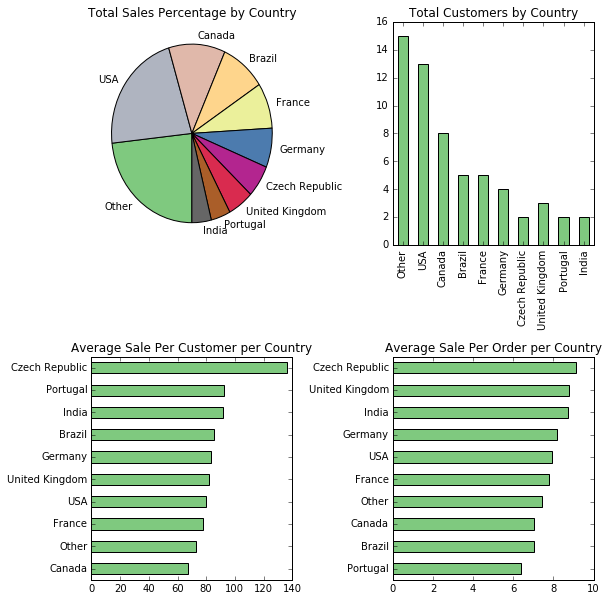

In [8]:
## Plot dimensions
regional_sales = run_query(query3)
regional_sales.set_index("country", drop=True, inplace=True)

#Prepare subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.5)

## Create first plot, sales percentage by country
sales_breakdown = regional_sales["total_sales_perc"].copy().rename("")
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title="Total Sales Percentage by Country",
    colormap=plt.cm.Accent)

##Create second plot
sales_breakdown = regional_sales["customer_count"].copy().rename("")
sales_breakdown.index.name = ""
sales_breakdown.plot.bar(
    ax=ax2,
    title="Total Customers by Country",
    colormap=plt.cm.Accent)


##Create third plot

sales_breakdown = regional_sales["avg_sale_per_customer"].copy().rename("")
sales_breakdown.index.name = ""

sales_breakdown = sales_breakdown.sort_values()
sales_breakdown.plot.barh(
    ax=ax3,
    title="Average Sale Per Customer per Country",
    colormap=plt.cm.Accent)


#Create fourth plot
sales_breakdown = regional_sales["avg_per_order"].copy().rename("")
sales_breakdown.index.name = ""
sales_breakdown = sales_breakdown.sort_values()
sales_breakdown.plot.barh(
    ax=ax4,
    title="Average Sale Per Order per Country",
    colormap=plt.cm.Accent)


The above analysis illustrates many points:

1. "Others" constitutes countries which have only one client, but they constitute nearly 1/4 of total sales together.

2. The Czech Republic has noticeably higher sales per customer and higher sales per order than any other country. The company should potentially investigate reasons for this, and consider increasing marketing to this area because of it's potentially high return.

## Problem: Sales of Individual Tracks vs Albums

"Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue."

There are two edge cases to be aware of (but ultimately do not influence the analysis)

1. "Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks."

2. "Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase."

For (1), I will ignore albums with few tracks. For (2), the company Chinook as already done analysis and found this only occurs rarely.


In [13]:
query4 = '''
         SELECT
             COUNT(DISTINCT(invoice_id)) AS number_of_invoices
         FROM invoice

         '''

run_query(query4)

,number_of_invoices
0,614


In [14]:
query4 = '''
        WITH
        all_info AS
        (
        SELECT
            *
        FROM invoice as i
        INNER JOIN invoice_line AS il ON il.invoice_id = i.invoice_id
        INNER JOIN track AS t ON t.track_id = il.track_id
        INNER JOIN album AS a ON a.album_id = t.track_id    
        )
        
       
        
        SELECT 
            *
        FROM all_info



         '''

run_query(query4)

,invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,invoice_line_id,...,album_id,media_type_id,genre_id,composer,milliseconds,bytes,unit_price:1,album_id:1,title,artist_id
0,2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.90,23,...,20,1,6,Sonny Boy Williamson [i],166060,5487056,0.99,201,Judas 0: B-Sides and Rarities,131
1,6,31,2017-01-10 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98,55,...,5,1,1,"Steven Tyler, Richie Supa",356519,11616195,0.99,30,BBC Sessions [Disc 1] [live],22
2,7,49,2017-01-12 00:00:00,Ordynacka 10,Warsaw,None,Poland,00-358,10.89,66,...,6,1,1,Alanis Morissette & Glenn Ballard,176117,5793082,0.99,42,Minha História,57
3,8,59,2017-01-13 00:00:00,"3,Raj Bhavan Road",Bangalore,None,India,560001,9.90,69,...,9,1,3,Apocalyptica,288208,9405526,0.99,81,One By One,84
4,9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91,77,...,21,1,7,Tradicional,99369,3225364,0.99,206,Core,134
5,9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91,85,...,20,1,6,Buddy Guy,433397,14184984,0.99,196,Retrospective I (1974-1980),128
6,12,42,2017-01-21 00:00:00,"9, Place Louis Barthou",Bordeaux,None,France,33000,3.96,102,...,10,1,1,Audioslave/Chris Cornell,334942,8041411,0.99,92,Use Your Illusion II,88
7,16,1,2017-01-26 00:00:00,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,8.91,111,...,9,1,3,Apocalyptica,369345,12033110,0.99,83,My Way: The Best Of Frank Sinatra [Disc 1],85
8,16,1,2017-01-26 00:00:00,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,8.91,112,...,4,1,1,AC/DC,215196,7032162,0.99,16,Black Sabbath,12
9,16,1,2017-01-26 00:00:00,"Av. Brigadeiro Faria Lima, 2170",São José dos Campos,SP,Brazil,12227-000,8.91,115,...,10,1,1,Audioslave/Chris Cornell,206053,4948095,0.99,93,Blue Moods,89
